# Sentimentent Analysis On Amazon Reviews

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from matplotlib import cm
import os
import re
sns.set_style("whitegrid")

warnings.filterwarnings("ignore")

## Load and Explore Dataset

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dir = "/content/drive/MyDrive/Project Sentiment Analysis"
os.chdir(dir)
print("Working Directory:", os.getcwd())

Working Directory: /content/drive/MyDrive/Project Sentiment Analysis


In [ ]:
file_path = '/content/drive/MyDrive/Project Sentiment Analysis/Reviews.csv'

dataset = pd.read_csv(file_path)
dataset.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
dataset.shape

(568454, 10)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [ ]:
features_for_modelling = ['Text','Score']
dataset = dataset[features_for_modelling]
dataset.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [ ]:
dataset.isnull().sum()

,0
Text,0
Score,0


In [ ]:
dataset.duplicated().sum()

174779

In [ ]:
dataset.drop_duplicates(inplace=True)

In [ ]:
dataset.shape

(393675, 2)

## Exploratory Data Analysis and Feature Generation

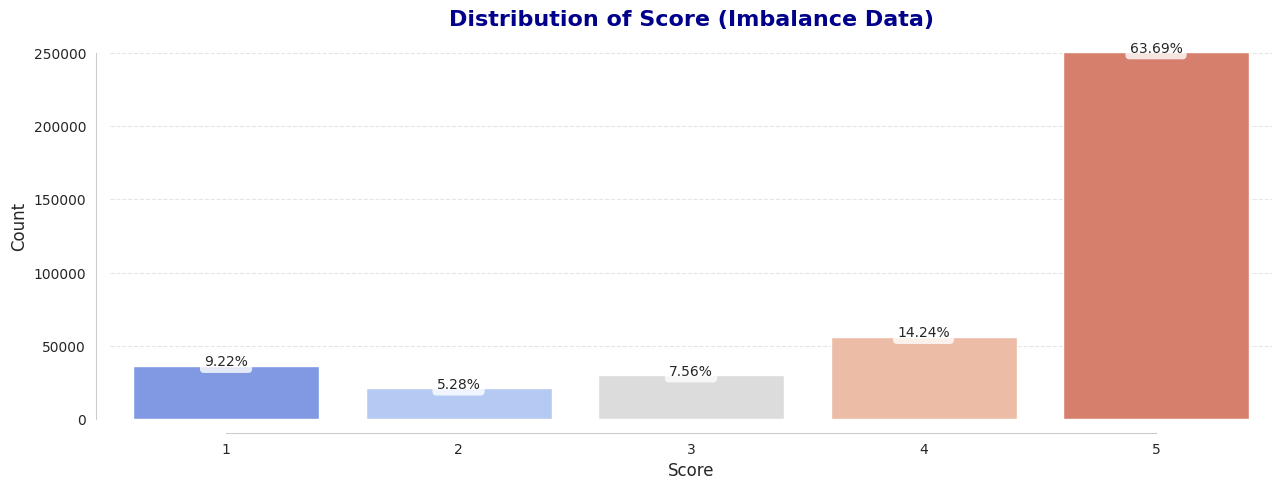

In [ ]:
plt.figure(figsize=(15,5))

ax = sns.countplot(data=dataset, x='Score', palette='coolwarm')
total = float(len(dataset))

for p in ax.patches:
    height=p.get_height()
    ax.text(
        p.get_x()+p.get_width()/2,
        height + 10,
        f"{(height/total)*100:.2f}%",
        ha='center',
        bbox=dict(facecolor='white', edgecolor='none',
                 alpha=0.8, boxstyle='round')
    )

ax.yaxis.grid(True, linestyle='--', alpha=0.5)

ax.set_title("Distribution of Score (Imbalance Data)", fontsize=16, fontweight='bold', color='darkblue')
ax.set_xlabel("Score", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

sns.despine(offset= 10, trim=True)
plt.savefig('Distribution_of_Score_Imbalance_Data', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.utils import resample

score_counts = dataset['Score'].value_counts()
min_count = 10_000

balanced_datasets = []
for score in score_counts.index:
    subset = dataset[dataset['Score'] == score]
    if len(subset) > min_count:
        subset = resample(subset, replace=False, n_samples=min_count, random_state=42)
    balanced_datasets.append(subset)

dataset_balanced = pd.concat(balanced_datasets).sample(frac=1, random_state=42)
dataset_balanced = dataset_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(dataset_balanced['Score'].value_counts())

Score
3    10000
2    10000
1    10000
5    10000
4    10000
Name: count, dtype: int64


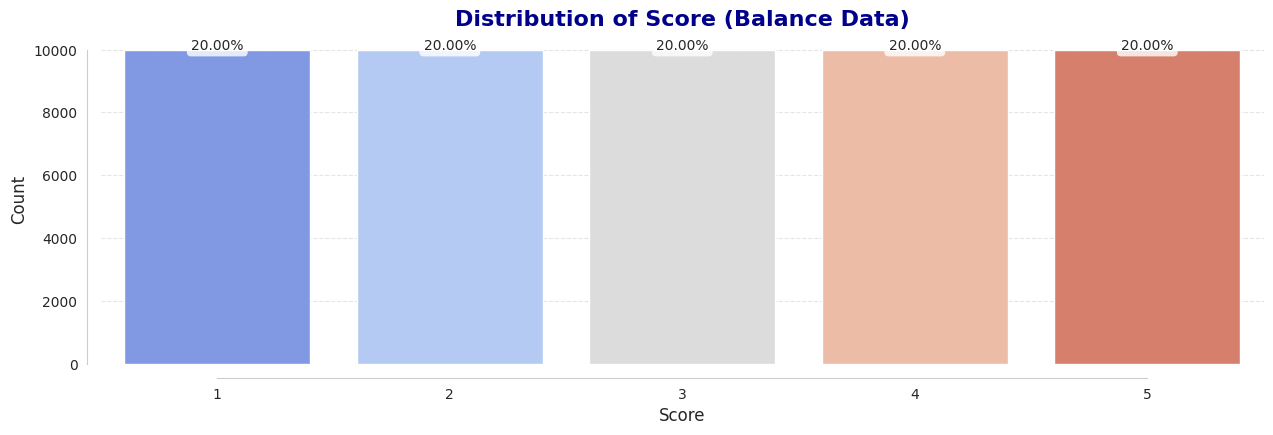

In [ ]:
plt.figure(figsize=(15,5))

ax = sns.countplot(data=dataset_balanced, x='Score', palette='coolwarm')
total = float(len(dataset_balanced))

for p in ax.patches:
    height=p.get_height()
    ax.text(
        p.get_x()+p.get_width()/2,
        height + 10,
        f"{(height/total)*100:.2f}%",
        ha='center',
        bbox=dict(facecolor='white', edgecolor='none',
                 alpha=0.8, boxstyle='round')
    )

ax.yaxis.grid(True, linestyle='--', alpha=0.5)

ax.set_title("Distribution of Score (Balance Data)", fontsize=16, fontweight='bold', color='darkblue')
ax.set_xlabel("Score", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

sns.despine(offset= 10, trim=True)
plt.savefig('Distribution_of_Score_Balance_Data', dpi=300, bbox_inches='tight')
plt.subplots_adjust(top=0.77)
plt.show()

In [ ]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', str(text))
    text = text.lower()
    return text

dataset_balanced['clean_text'] = dataset_balanced['Text'].apply(clean_text)

In [ ]:
!pip install -q wordcloud

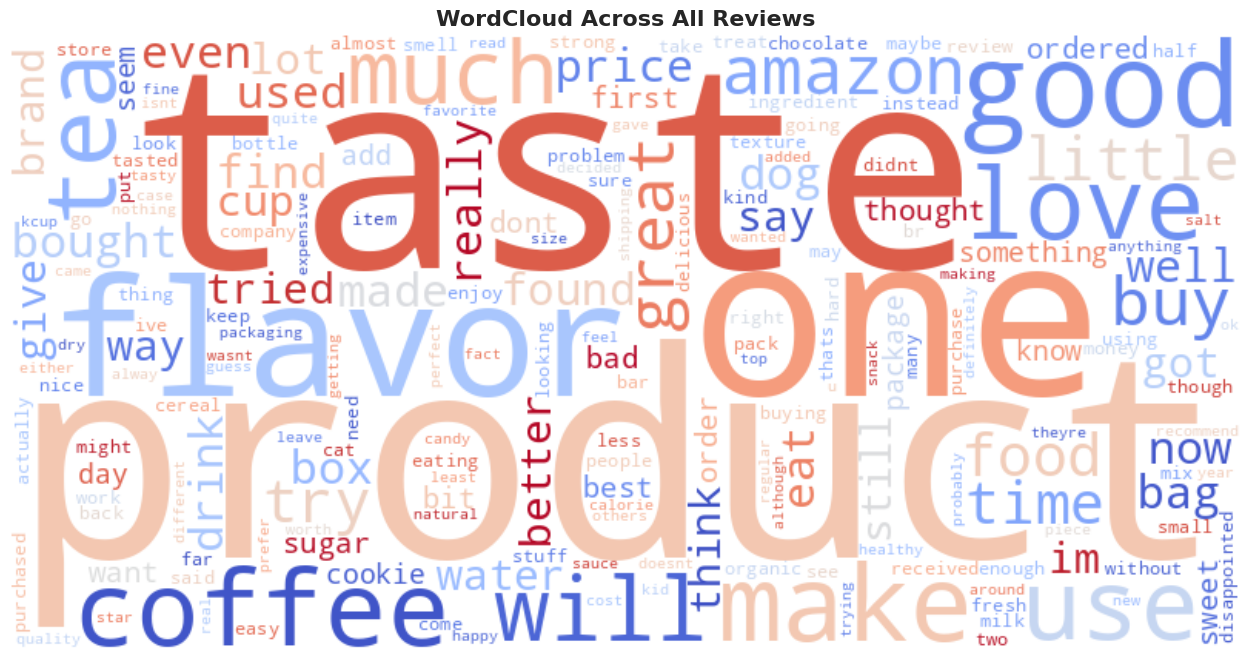

In [ ]:
from wordcloud import WordCloud

text = " ".join(review for review in dataset_balanced['clean_text'])
color_map = cm.get_cmap("coolwarm")
wordcloud = WordCloud(
    width=800, height=400,
    background_color='white',
    colormap=color_map).generate(text)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud Across All Reviews", fontsize=16, fontweight='bold')
plt.savefig('WordCloud_Across_All_Reviews.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
def categorize_score(value):
    if value <=3:
        return 'Negative'
    else:
        return 'Positive'

dataset_balanced['Sentiment'] = dataset_balanced['Score'].apply(categorize_score)
dataset_balanced.head()

,Text,Score,clean_text,Sentiment
0,So I read all the fantastic reviews of these l...,3,so i read all the fantastic reviews of these l...,Negative
1,I had the opportunity to try a packet of Truvi...,3,i had the opportunity to try a packet of truvi...,Negative
2,I sort of expected this to be more than it is....,2,i sort of expected this to be more than it is ...,Negative
3,I have been buying these from my Vet in the Me...,1,i have been buying these from my vet in the me...,Negative
4,Has a good weight and texture (material) givin...,5,has a good weight and texture material giving ...,Positive


In [ ]:
dataset_balanced['word_count'] = dataset_balanced['clean_text'].apply(lambda x: len(str(x).split()))
dataset_balanced['word_count'].describe()

,word_count
count,50000.000000
mean,86.261760
std,81.977929
min,6.000000
25%,36.000000
50%,62.000000
75%,106.000000
max,2105.000000


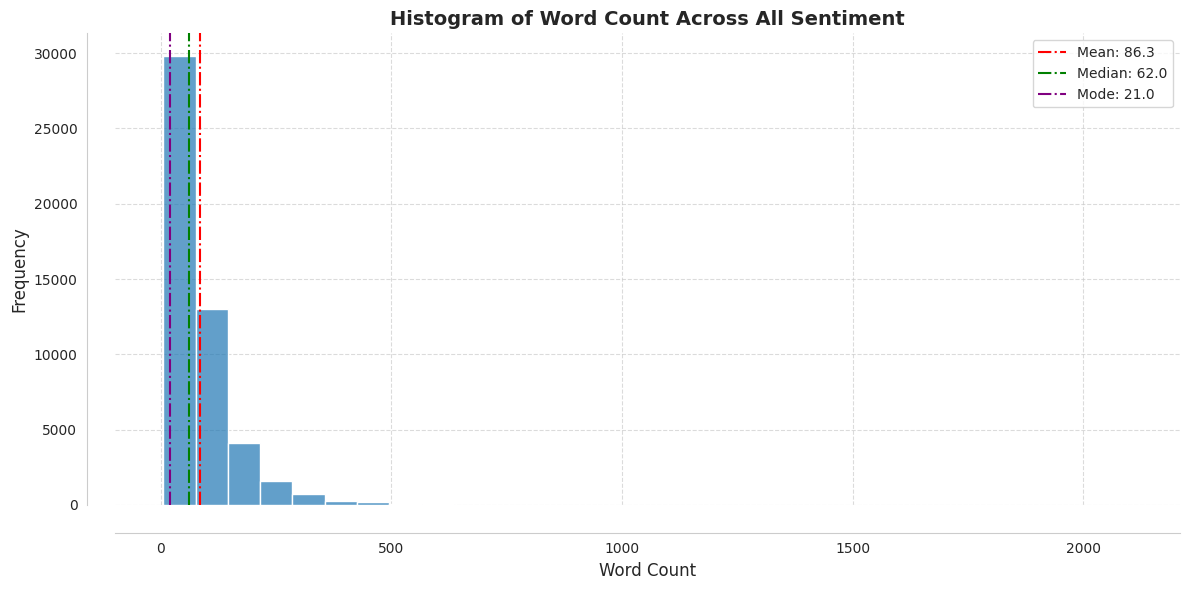

In [ ]:
plt.figure(figsize=(12, 6))

sns.histplot(data = dataset_balanced,
             x = 'word_count',
             bins=30, palette='coolwarm',
             alpha=0.7)

mean = dataset_balanced['word_count'].mean()
median = dataset_balanced['word_count'].median()
mode = dataset_balanced['word_count'].mode()[0]

sns.despine(offset=20)

plt.axvline(mean, color='red', linestyle='-.', label=f"Mean: {mean:.1f}")
plt.axvline(median, color='green', linestyle='-.', label=f"Median: {median:.1f}")
plt.axvline(mode, color='purple', linestyle='-.', label=f"Mode: {mode:.1f}")

plt.title('Histogram of Word Count Across All Sentiment', fontsize=14, fontweight='bold')
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.tight_layout()
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.savefig('Histogram of Word Count Across All Sentiment.png', dpi=300, bbox_inches='tight')
plt.show()

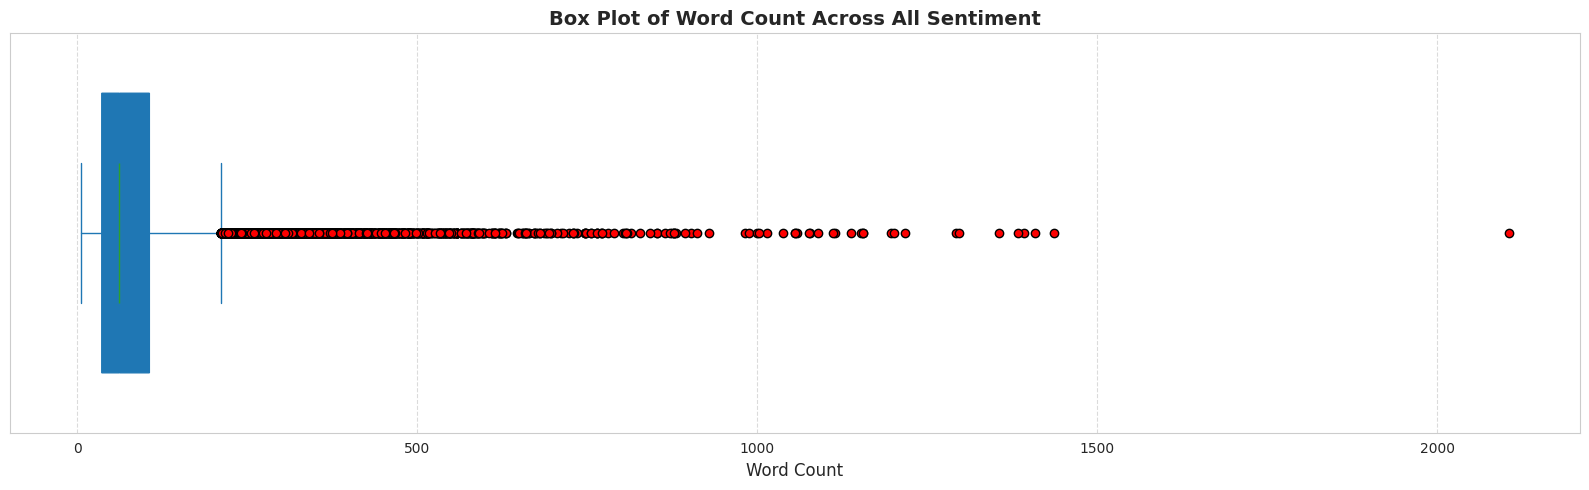

In [ ]:
plt.figure(figsize=(16, 5))
dataset_balanced['word_count'].plot(kind='box', patch_artist=True, notch=True,
                    vert=False, widths=0.7, flierprops=dict(
                        markerfacecolor='red', marker='o'))

plt.title('Box Plot of Word Count Across All Sentiment', fontsize=14, fontweight='bold')
plt.xlabel('Word Count', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.yticks([])
plt.tight_layout()
plt.savefig('Box Plot of Word Count Across All Sentiment.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
dataset_balanced.groupby("Sentiment")['word_count'].describe()

,count,mean,std,min,25%,50%,75%,max
Sentiment,,,,,,,,
Negative,30000.0,88.6490,81.862655,6.0,38.0,65.0,110.0,2105.0
Positive,20000.0,82.6809,82.022407,6.0,34.0,58.0,101.0,1409.0


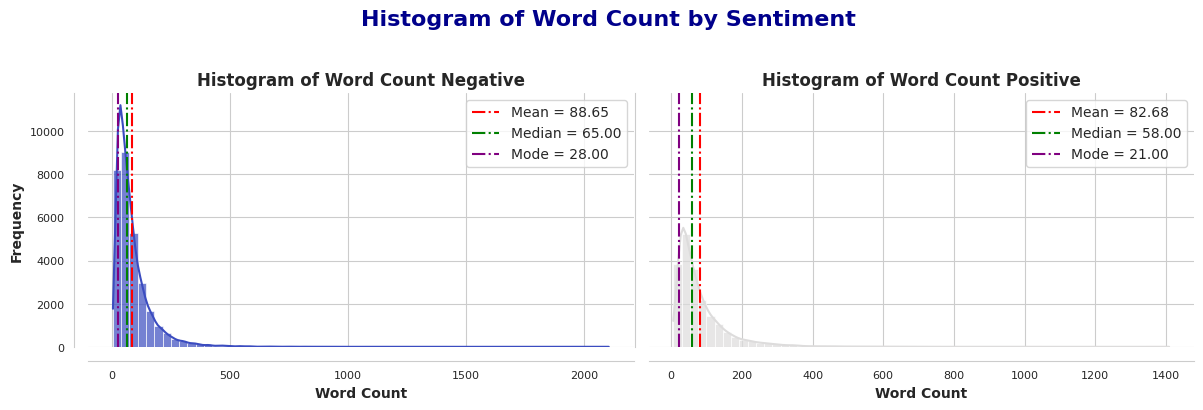

In [ ]:
from matplotlib.cm import get_cmap

cols = 2
rows = 1
unique_sentiments = dataset_balanced["Sentiment"].unique()
fig, axes = plt.subplots(rows, cols, figsize=(12, 4), sharey=True)
axes = axes.flatten()

cmap = get_cmap("coolwarm")
colors = [cmap(i/len(unique_sentiments)) for i in range(len(unique_sentiments))]

for i, (sentiment, ax) in enumerate(zip(unique_sentiments, axes)):
    sentiment_data = dataset_balanced[dataset_balanced['Sentiment']==sentiment]
    sns.histplot(
        data=sentiment_data,
        x='word_count',
        bins=60,
        color=colors[i],
        alpha=0.7,
        ax=ax, kde=True
    )
    mean=sentiment_data["word_count"].mean()
    median=sentiment_data["word_count"].median()
    mode=sentiment_data["word_count"].mode()[0]

    ax.axvline(mean, linestyle='-.', color='red', label=f"Mean = {mean:.2f}")
    ax.axvline(median, linestyle='-.', color='green', label=f"Median = {median:.2f}")
    ax.axvline(mode, linestyle='-.', color='purple', label=f"Mode = {mode:.2f}")

    ax.set_title(f"Histogram of Word Count {sentiment}", fontsize=12, fontweight='bold')
    ax.set_xlabel("Word Count", fontsize=10, fontweight='bold')
    ax.set_ylabel("Frequency", fontsize=10, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.legend(fontsize=10)

plt.suptitle("Histogram of Word Count by Sentiment", fontsize=16, fontweight='bold', color='darkblue')
plt.tight_layout()
plt.subplots_adjust(top=0.77)

sns.despine(offset=10)

plt.savefig("Histogram_of_Word_Count_by_Sentiment.png", dpi=300, bbox_inches='tight')
plt.show()

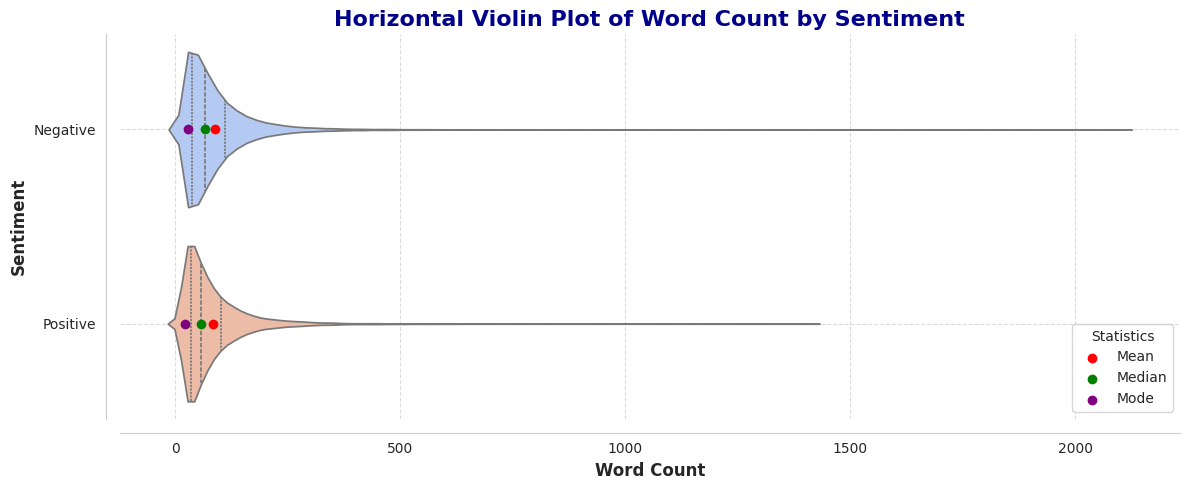

In [ ]:
plt.figure(figsize=(12, 5))

sns.violinplot(
    data=dataset_balanced,
    y='Sentiment',
    x='word_count',
    palette="coolwarm",
    inner="quartile"
)

unique_sentiments = dataset_balanced['Sentiment'].unique()
for sentiment in unique_sentiments:
    sentiment_data = dataset_balanced[dataset_balanced['Sentiment'] == sentiment]['word_count']

    mean = sentiment_data.mean()
    median = sentiment_data.median()
    mode = sentiment_data.mode()[0]
    y_pos = np.where(unique_sentiments == sentiment)[0][0]

    plt.scatter(mean, y_pos, color='red', label='Mean' if sentiment == unique_sentiments[0] else "", zorder=3)
    plt.scatter(median, y_pos, color='green', label='Median' if sentiment == unique_sentiments[0] else "", zorder=3)
    plt.scatter(mode, y_pos, color='purple', label='Mode' if sentiment == unique_sentiments[0] else "", zorder=3)

plt.title("Horizontal Violin Plot of Word Count by Sentiment", fontsize=16, fontweight='bold', color='darkblue')
plt.ylabel("Sentiment", fontsize=12, fontweight='bold')
plt.xlabel("Word Count", fontsize=12, fontweight='bold')
plt.legend(title="Statistics", loc="lower right", fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.7)

sns.despine(offset=10)

plt.tight_layout()
plt.savefig('Horizontal_Violin_Plot_of_Word_Count_by_Sentiment.png', dpi=300, bbox_inches='tight')
plt.show()

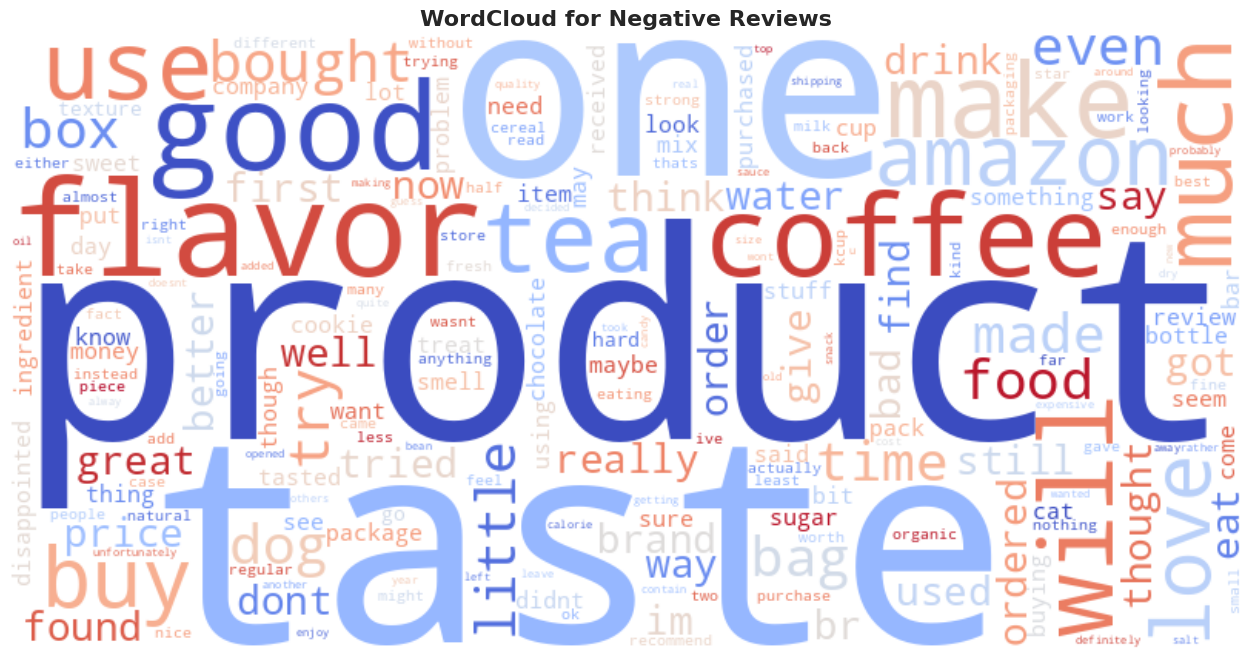

In [ ]:
negative = " ".join(review for review in dataset_balanced[dataset_balanced['Sentiment'] == 'Negative']['clean_text'])
color_map = cm.get_cmap("coolwarm")
wordcloud = WordCloud(
    width=800, height=400,
    background_color='white',
    colormap = color_map
    ).generate(negative)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud for Negative Reviews", fontsize=16, fontweight='bold')
plt.savefig('WordCloud_for_Negative_Reviews.png', dpi=300, bbox_inches='tight')
plt.show()

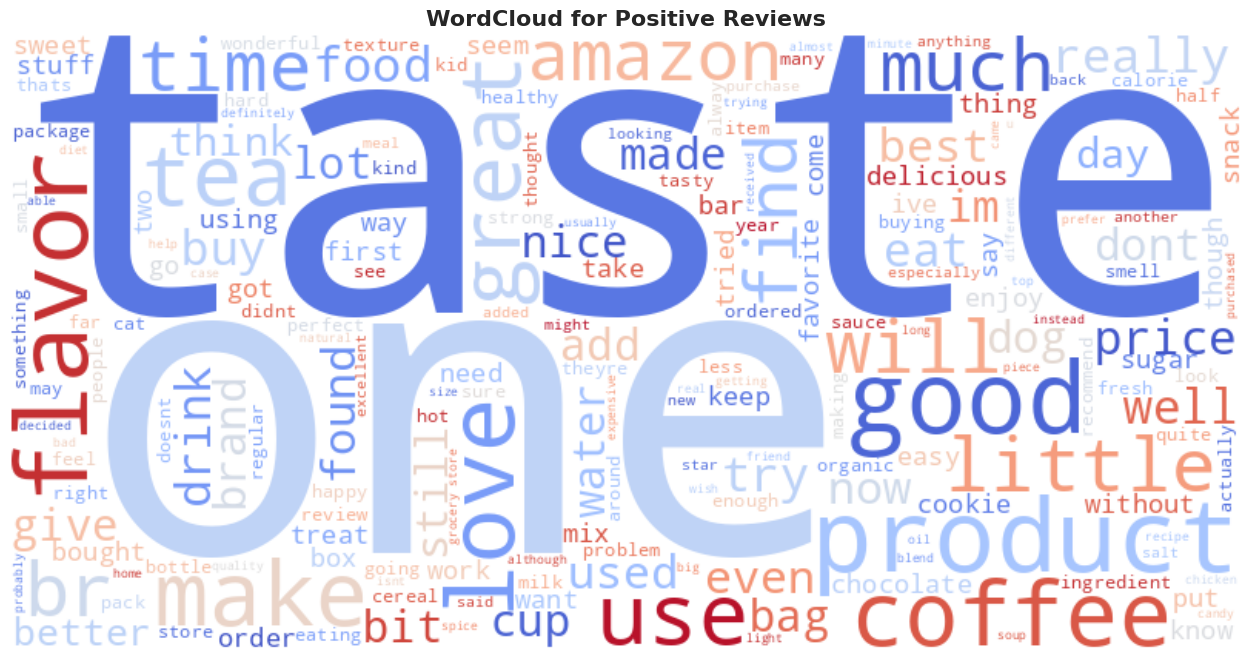

In [ ]:
positive = " ".join(review for review in dataset_balanced[dataset_balanced['Sentiment'] == 'Positive']['clean_text'])
color_map = cm.get_cmap("coolwarm")
wordcloud = WordCloud(
    width=800, height=400,
    background_color='white',
    colormap = color_map
    ).generate(positive)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud for Positive Reviews", fontsize=16, fontweight='bold')
plt.savefig('WordCloud_for_Positive_Reviews.png', dpi=300, bbox_inches='tight')
plt.show()

## Model Building

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import joblib

X_train, X_test, y_train, y_test = train_test_split(dataset_balanced['clean_text'],
                                                    dataset_balanced['Sentiment'],
                                                    test_size=0.01, random_state=42)

vectorizer = CountVectorizer(stop_words='english', max_features=5000)
X_count = vectorizer.fit_transform(X_train)
joblib.dump(vectorizer, 'vectorizer.joblib')

X_train, X_val, y_train, y_val = train_test_split(X_count, y_train, test_size=0.2,
                                                  random_state=42)

print("Data Size:")
print(f" Training {X_train.shape[0]}")
print(f" Validating {X_val.shape[0]}")
print(f" Testing {X_test.shape[0]}")

Data Size:
 Training 39600
 Validating 9900
 Testing 500


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

model_lreg = LogisticRegression()
model_lreg.fit(X_train, y_train)

y_pred_train = model_lreg.predict(X_train)
y_pred_val = model_lreg.predict(X_val)
print("\nClassification Report Training:\n", classification_report(y_train, y_pred_train))
print("\nClassification Report Validation:\n", classification_report(y_val, y_pred_val))


Classification Report Training:
               precision    recall  f1-score   support

    Negative       0.87      0.89      0.88     23721
    Positive       0.84      0.81      0.82     15879

    accuracy                           0.86     39600
   macro avg       0.86      0.85      0.85     39600
weighted avg       0.86      0.86      0.86     39600


Classification Report Validation:
               precision    recall  f1-score   support

    Negative       0.83      0.84      0.84      5995
    Positive       0.75      0.73      0.74      3905

    accuracy                           0.80      9900
   macro avg       0.79      0.79      0.79      9900
weighted avg       0.80      0.80      0.80      9900



In [ ]:
from sklearn.naive_bayes import MultinomialNB

model_nb = MultinomialNB(alpha=0.5)
model_nb.fit(X_train,y_train)

y_pred_train = model_nb.predict(X_train)
y_pred_val = model_nb.predict(X_val)
print("\nClassification Report Training:\n", classification_report(y_train, y_pred_train))
print("\nClassification Report Validation:\n", classification_report(y_val, y_pred_val))


Classification Report Training:
               precision    recall  f1-score   support

    Negative       0.86      0.82      0.84     23721
    Positive       0.75      0.79      0.77     15879

    accuracy                           0.81     39600
   macro avg       0.80      0.81      0.81     39600
weighted avg       0.81      0.81      0.81     39600


Classification Report Validation:
               precision    recall  f1-score   support

    Negative       0.84      0.82      0.83      5995
    Positive       0.73      0.76      0.75      3905

    accuracy                           0.80      9900
   macro avg       0.79      0.79      0.79      9900
weighted avg       0.80      0.80      0.80      9900



In [ ]:
from sklearn.tree import DecisionTreeClassifier

model_dtree = DecisionTreeClassifier(
    criterion='gini',
    random_state=42
)

model_dtree.fit(X_train, y_train)
y_pred_train = model_dtree.predict(X_train)
y_pred_val = model_dtree.predict(X_val)

print("\nClassification Report Training:\n", classification_report(y_train, y_pred_train))
print("\nClassification Report Validation:\n", classification_report(y_val, y_pred_val))


Classification Report Training:
               precision    recall  f1-score   support

    Negative       1.00      1.00      1.00     23721
    Positive       1.00      1.00      1.00     15879

    accuracy                           1.00     39600
   macro avg       1.00      1.00      1.00     39600
weighted avg       1.00      1.00      1.00     39600


Classification Report Validation:
               precision    recall  f1-score   support

    Negative       0.73      0.74      0.74      5995
    Positive       0.60      0.59      0.59      3905

    accuracy                           0.68      9900
   macro avg       0.67      0.66      0.67      9900
weighted avg       0.68      0.68      0.68      9900



## Hyperparameter Tunning

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'max_iter': [100, 200, 300]
}

grid_search = GridSearchCV(
    estimator=model_lreg,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 200, 300],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['lbfgs', 'liblinear', 'saga']},
             scoring='accuracy', verbose=1)

In [ ]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score", grid_search.best_score_)

Best Parameters: {'C': 0.1, 'max_iter': 200, 'penalty': 'l2', 'solver': 'saga'}
Best Score 0.80475


In [ ]:
logr_model = LogisticRegression(C=1,
                                max_iter=200,
                                penalty='l2',
                                solver='saga')
logr_model.fit(X_train, y_train)

y_pred_train = model_lreg.predict(X_train)
y_pred_val = model_lreg.predict(X_val)
print("\nClassification Report Training:\n", classification_report(y_train, y_pred_train))
print("\nClassification Report Validation:\n", classification_report(y_val, y_pred_val))


Classification Report Training:
               precision    recall  f1-score   support

    Negative       0.87      0.90      0.88     22789
    Positive       0.84      0.81      0.82     15211

    accuracy                           0.86     38000
   macro avg       0.86      0.85      0.85     38000
weighted avg       0.86      0.86      0.86     38000


Classification Report Validation:
               precision    recall  f1-score   support

    Negative       0.83      0.84      0.84      5729
    Positive       0.76      0.73      0.75      3771

    accuracy                           0.80      9500
   macro avg       0.79      0.79      0.79      9500
weighted avg       0.80      0.80      0.80      9500



In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}

grid_search = GridSearchCV(estimator=model_nb, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score", grid_search.best_score_)

Best Parameters: {'alpha': 5.0}
Best Score 0.7912626262626262


In [ ]:
nb_model = MultinomialNB(alpha=5.0)
nb_model.fit(X_train, y_train)

y_pred_train = nb_model.predict(X_train)
y_pred_val = nb_model.predict(X_val)
print("\nClassification Report Training:\n", classification_report(y_train, y_pred_train))
print("\nClassification Report Validation:\n", classification_report(y_val, y_pred_val))


Classification Report Training:
               precision    recall  f1-score   support

    Negative       0.85      0.83      0.84     23721
    Positive       0.75      0.79      0.77     15879

    accuracy                           0.81     39600
   macro avg       0.80      0.81      0.80     39600
weighted avg       0.81      0.81      0.81     39600


Classification Report Validation:
               precision    recall  f1-score   support

    Negative       0.84      0.82      0.83      5995
    Positive       0.73      0.76      0.74      3905

    accuracy                           0.79      9900
   macro avg       0.78      0.79      0.79      9900
weighted avg       0.80      0.79      0.79      9900



## Implementation Model

In [ ]:
from joblib import load

loaded_vectorizer = load('vectorizer.joblib')

X_test_count = loaded_vectorizer.transform(X_test)
y_pred_test = model_lreg.predict(X_test_count)
print("\nReport Testing:\n", classification_report(y_test, y_pred_test))


Report Testing:
               precision    recall  f1-score   support

    Negative       0.81      0.85      0.83       284
    Positive       0.79      0.73      0.76       216

    accuracy                           0.80       500
   macro avg       0.80      0.79      0.79       500
weighted avg       0.80      0.80      0.80       500



In [ ]:
from joblib import load

loaded_vectorizer = load('vectorizer.joblib')

X_test_count = loaded_vectorizer.transform(X_test)
y_pred_test = nb_model.predict(X_test_count)
print("\nReport Testing:\n", classification_report(y_test, y_pred_test))


Report Testing:
               precision    recall  f1-score   support

    Negative       0.83      0.80      0.81       284
    Positive       0.75      0.78      0.76       216

    accuracy                           0.79       500
   macro avg       0.79      0.79      0.79       500
weighted avg       0.79      0.79      0.79       500

